# Complete E-Waste Classification System - Real Dataset

This notebook provides a complete demonstration of the E-Waste Classification System using the real dataset.
It includes data loading, model training, evaluation, and confusion matrix visualization.

## 📋 Table of Contents
1. [Setup and Configuration](#setup)
2. [Dataset Loading and Analysis](#data-loading)
3. [Data Preprocessing](#data-preprocessing)
4. [Model Building](#model-building)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)
7. [Confusion Matrix](#confusion-matrix)
8. [Prediction Examples](#prediction-examples)

## 1. Setup and Configuration {#setup}

Let's start by importing necessary libraries and setting up the environment.

In [14]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
packages = ['tensorflow', 'numpy', 'pandas', 'matplotlib', 'seaborn', 'scikit-learn', 'pillow']
for package in packages:
    install_package(package)

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [15]:
# Import necessary libraries
import os
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn imports
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0
GPU Available: []


In [16]:
# Configuration dictionary
config = {
    'model': {
        'name': 'EfficientNetV2B0',
        'input_shape': [224, 224, 3],
        'num_classes': 10,
        'weights': 'imagenet'
    },
    'training': {
        'batch_size': 32,
        'epochs': 10,
        'learning_rate': 0.001,
        'early_stopping_patience': 5,
        'reduce_lr_patience': 3,
        'reduce_lr_factor': 0.5
    },
    'data': {
        'data_dir': 'E:\E-Waste-Classification\data\modified-dataset',
        'target_size': (224, 224),
        'augmentation': {
            'rotation_range': 20,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'shear_range': 0.2,
            'zoom_range': 0.2,
            'horizontal_flip': True,
            'fill_mode': 'nearest'
        }
    },
    'classes': [
        "Battery", "Keyboard", "Microwave", "Mobile", "Mouse",
        "PCB", "Player", "Printer", "Television", "Washing Machine"
    ]
}

print("📋 Configuration loaded:")
print(f"   Model: {config['model']['name']}")
print(f"   Classes: {len(config['classes'])}")
print(f"   Input Shape: {config['model']['input_shape']}")
print(f"   Batch Size: {config['training']['batch_size']}")
print(f"   Dataset Path: {config['data']['data_dir']}")

# Display e-waste categories
print("\n🗂️  E-Waste Categories:")
for i, category in enumerate(config['classes'], 1):
    print(f"   {i:2d}. {category}")

📋 Configuration loaded:
   Model: EfficientNetV2B0
   Classes: 10
   Input Shape: [224, 224, 3]
   Batch Size: 32
   Dataset Path: E:\E-Waste-Classification\data\modified-dataset

🗂️  E-Waste Categories:
    1. Battery
    2. Keyboard
    3. Microwave
    4. Mobile
    5. Mouse
    6. PCB
    7. Player
    8. Printer
    9. Television
   10. Washing Machine


## 2. Dataset Loading and Analysis {#data-loading}

Load and analyze the real E-Waste dataset.

In [17]:
# Check if dataset exists and analyze its structure
def analyze_dataset(data_dir):
    """Analyze the dataset structure and count images per class."""
    dataset_info = {}
    
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_dir, split)
        if not os.path.exists(split_path):
            print(f"⚠️  Warning: {split} directory not found at {split_path}")
            continue
            
        dataset_info[split] = {}
        total_images = 0
        
        for class_name in config['classes']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                count = len(image_files)
                dataset_info[split][class_name] = count
                total_images += count
            else:
                dataset_info[split][class_name] = 0
                
        dataset_info[split]['total'] = total_images
    
    return dataset_info

# Analyze the dataset
print("🔍 Analyzing dataset structure...")
dataset_info = analyze_dataset(config['data']['data_dir'])

# Display dataset information
print(f"\n📊 Dataset Analysis:")
print("=" * 80)

for split in ['train', 'val', 'test']:
    if split in dataset_info:
        print(f"\n{split.upper()} SET:")
        print(f"   Total images: {dataset_info[split]['total']}")
        print(f"   Images per class:")
        for class_name in config['classes']:
            count = dataset_info[split].get(class_name, 0)
            print(f"     {class_name:<15}: {count:>4} images")

# Calculate total dataset size
total_images = sum([dataset_info[split]['total'] for split in dataset_info.keys()])
print(f"\n📈 TOTAL DATASET: {total_images} images")
print("=" * 80)

🔍 Analyzing dataset structure...

📊 Dataset Analysis:

TRAIN SET:
   Total images: 2400
   Images per class:
     Battery        :  240 images
     Keyboard       :  240 images
     Microwave      :  240 images
     Mobile         :  240 images
     Mouse          :  240 images
     PCB            :  240 images
     Player         :  240 images
     Printer        :  240 images
     Television     :  240 images
     Washing Machine:  240 images

VAL SET:
   Total images: 300
   Images per class:
     Battery        :   30 images
     Keyboard       :   30 images
     Microwave      :   30 images
     Mobile         :   30 images
     Mouse          :   30 images
     PCB            :   30 images
     Player         :   30 images
     Printer        :   30 images
     Television     :   30 images
     Washing Machine:   30 images

TEST SET:
   Total images: 300
   Images per class:
     Battery        :   30 images
     Keyboard       :   30 images
     Microwave      :   30 images
    

In [18]:
# Check if dataset exists and analyze its structure
def analyze_dataset(data_dir):
    """Analyze the dataset structure and count images per class."""
    dataset_info = {}
    
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_dir, split)
        if not os.path.exists(split_path):
            print(f"⚠️  Warning: {split} directory not found at {split_path}")
            continue
            
        dataset_info[split] = {}
        total_images = 0
        
        for class_name in config['classes']:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
                count = len(image_files)
                dataset_info[split][class_name] = count
                total_images += count
            else:
                dataset_info[split][class_name] = 0
                
        dataset_info[split]['total'] = total_images
    
    return dataset_info

# Analyze the dataset
print("🔍 Analyzing dataset structure...")
dataset_info = analyze_dataset(config['data']['data_dir'])

# Display dataset information
print(f"\n📊 Dataset Analysis:")
print("=" * 80)

for split in ['train', 'val', 'test']:
    if split in dataset_info:
        print(f"\n{split.upper()} SET:")
        print(f"   Total images: {dataset_info[split]['total']}")
        print(f"   Images per class:")
        for class_name in config['classes']:
            count = dataset_info[split].get(class_name, 0)
            print(f"     {class_name:<15}: {count:>4} images")

# Calculate total dataset size
total_images = sum([dataset_info[split]['total'] for split in dataset_info.keys()])
print(f"\n📈 TOTAL DATASET: {total_images} images")
print("=" * 80)

🔍 Analyzing dataset structure...

📊 Dataset Analysis:

TRAIN SET:
   Total images: 2400
   Images per class:
     Battery        :  240 images
     Keyboard       :  240 images
     Microwave      :  240 images
     Mobile         :  240 images
     Mouse          :  240 images
     PCB            :  240 images
     Player         :  240 images
     Printer        :  240 images
     Television     :  240 images
     Washing Machine:  240 images

VAL SET:
   Total images: 300
   Images per class:
     Battery        :   30 images
     Keyboard       :   30 images
     Microwave      :   30 images
     Mobile         :   30 images
     Mouse          :   30 images
     PCB            :   30 images
     Player         :   30 images
     Printer        :   30 images
     Television     :   30 images
     Washing Machine:   30 images

TEST SET:
   Total images: 300
   Images per class:
     Battery        :   30 images
     Keyboard       :   30 images
     Microwave      :   30 images
    

📊 Visualizing dataset distribution...


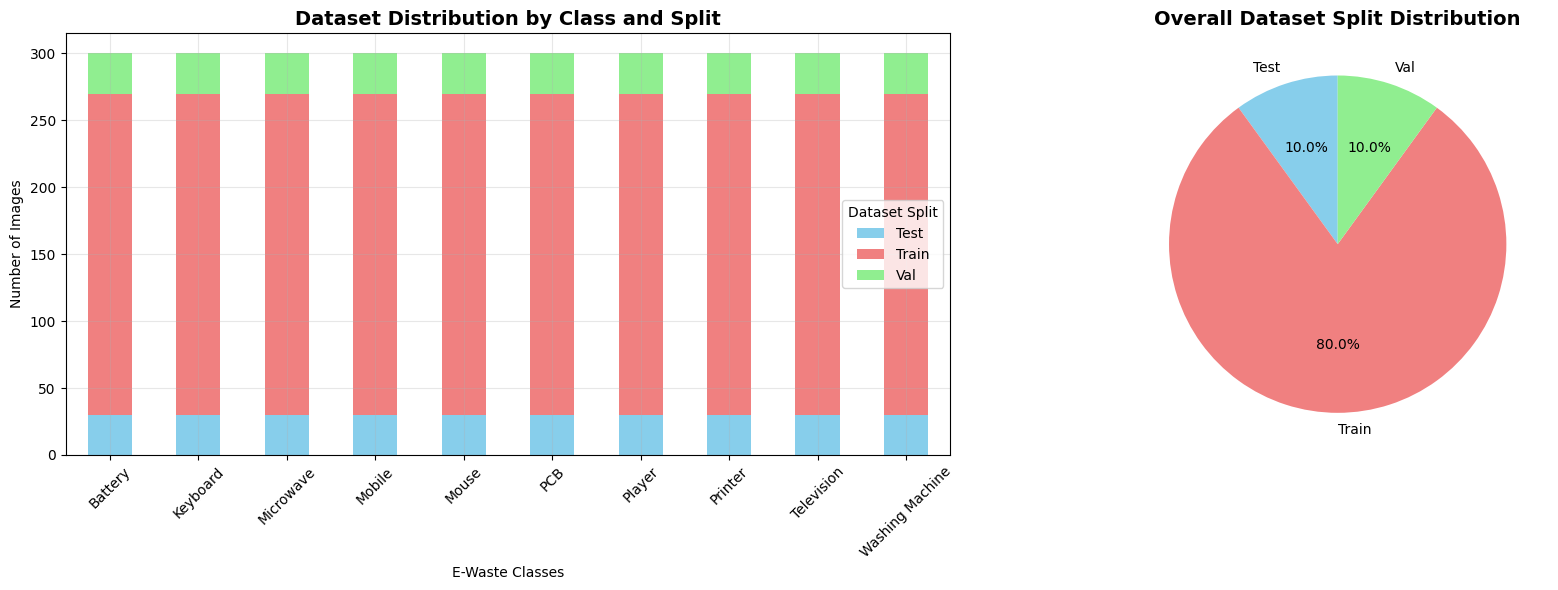


📊 Dataset Split Percentages:
   Test: 300 images (10.0%)
   Train: 2400 images (80.0%)
   Val: 300 images (10.0%)


In [19]:
# Visualize dataset distribution
print("📊 Visualizing dataset distribution...")

# Create DataFrame for visualization
data_for_plot = []
for split in ['train', 'val', 'test']:
    if split in dataset_info:
        for class_name in config['classes']:
            count = dataset_info[split].get(class_name, 0)
            data_for_plot.append({
                'Split': split.capitalize(),
                'Class': class_name,
                'Count': count
            })

df_plot = pd.DataFrame(data_for_plot)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Stacked bar chart showing distribution across splits
pivot_df = df_plot.pivot(index='Class', columns='Split', values='Count')
pivot_df.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Dataset Distribution by Class and Split', fontsize=14, fontweight='bold')
axes[0].set_xlabel('E-Waste Classes')
axes[0].set_ylabel('Number of Images')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Dataset Split')
axes[0].grid(True, alpha=0.3)

# Pie chart showing total distribution across splits
split_totals = df_plot.groupby('Split')['Count'].sum()
axes[1].pie(split_totals.values, labels=split_totals.index, autopct='%1.1f%%', 
           colors=['skyblue', 'lightcoral', 'lightgreen'], startangle=90)
axes[1].set_title('Overall Dataset Split Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Display split percentages
print(f"\n📊 Dataset Split Percentages:")
for split, total in split_totals.items():
    percentage = (total / total_images) * 100
    print(f"   {split.capitalize()}: {total} images ({percentage:.1f}%)")

🖼️  Sample images from each class:


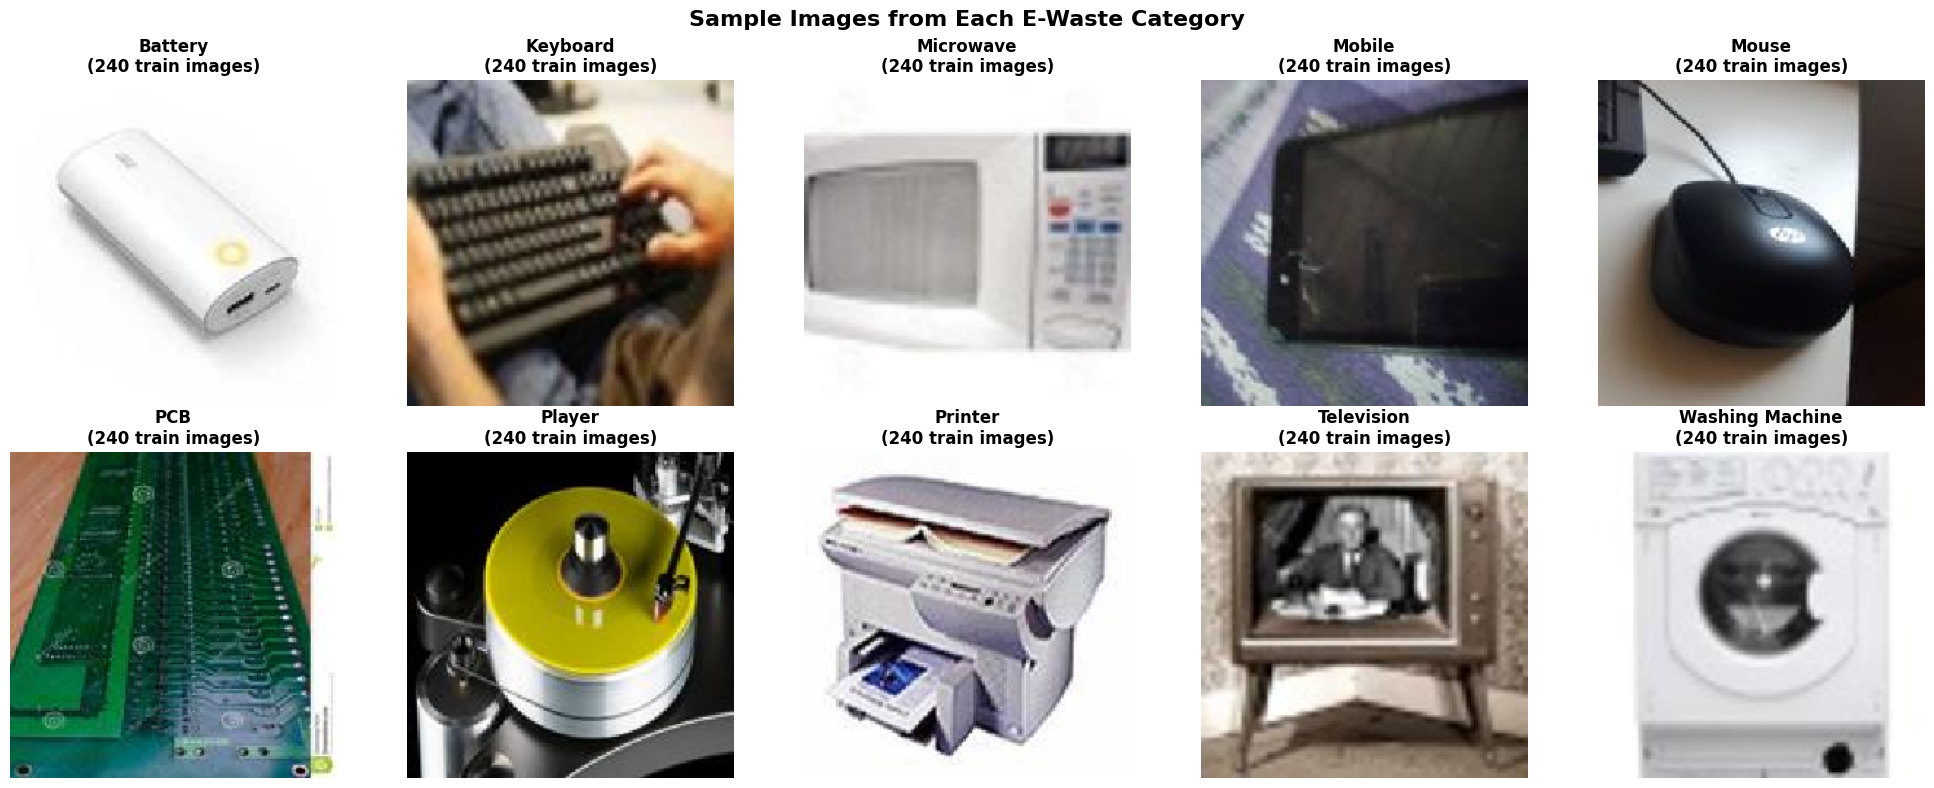

✅ Dataset analysis completed!


In [20]:
# Display sample images from each class
print("🖼️  Sample images from each class:")

def load_sample_images(data_dir, classes, split='train', samples_per_class=1):
    """Load sample images from each class."""
    sample_images = {}
    
    for class_name in classes:
        class_path = os.path.join(data_dir, split, class_name)
        if os.path.exists(class_path):
            image_files = [f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            if image_files:
                # Select random sample images
                selected_files = np.random.choice(image_files, 
                                                min(samples_per_class, len(image_files)), 
                                                replace=False)
                
                sample_images[class_name] = []
                for img_file in selected_files:
                    img_path = os.path.join(class_path, img_file)
                    try:
                        img = load_img(img_path, target_size=config['data']['target_size'])
                        sample_images[class_name].append(img)
                    except Exception as e:
                        print(f"   ⚠️  Error loading {img_path}: {e}")
    
    return sample_images

# Load sample images
sample_images = load_sample_images(config['data']['data_dir'], config['classes'])

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, class_name in enumerate(config['classes']):
    if class_name in sample_images and sample_images[class_name]:
        img = sample_images[class_name][0]  # Show first sample
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}\n({dataset_info["train"].get(class_name, 0)} train images)', 
                         fontsize=12, fontweight='bold')
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f'No images\nfound for\n{class_name}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(class_name, fontsize=12)
        axes[i].axis('off')

plt.suptitle('Sample Images from Each E-Waste Category', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Dataset analysis completed!")

## 3. Data Preprocessing {#data-preprocessing}

Set up data generators for training, validation, and testing.

In [21]:
# Set up data generators
print("🔄 Setting up data generators...")

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=config['data']['augmentation']['rotation_range'],
    width_shift_range=config['data']['augmentation']['width_shift_range'],
    height_shift_range=config['data']['augmentation']['height_shift_range'],
    shear_range=config['data']['augmentation']['shear_range'],
    zoom_range=config['data']['augmentation']['zoom_range'],
    horizontal_flip=config['data']['augmentation']['horizontal_flip'],
    fill_mode=config['data']['augmentation']['fill_mode']
)

# Validation and test data generators (no augmentation, only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(config['data']['data_dir'], 'train'),
    target_size=config['data']['target_size'],
    batch_size=config['training']['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(config['data']['data_dir'], 'val'),
    target_size=config['data']['target_size'],
    batch_size=config['training']['batch_size'],
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(config['data']['data_dir'], 'test'),
    target_size=config['data']['target_size'],
    batch_size=config['training']['batch_size'],
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print("✅ Data generators created successfully!")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Number of classes: {train_generator.num_classes}")
print(f"   Class indices: {train_generator.class_indices}")

🔄 Setting up data generators...
Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
✅ Data generators created successfully!
   Training samples: 2400
   Validation samples: 300
   Test samples: 300
   Number of classes: 10
   Class indices: {'Battery': 0, 'Keyboard': 1, 'Microwave': 2, 'Mobile': 3, 'Mouse': 4, 'PCB': 5, 'Player': 6, 'Printer': 7, 'Television': 8, 'Washing Machine': 9}


🔍 Visualizing data augmentation effects...


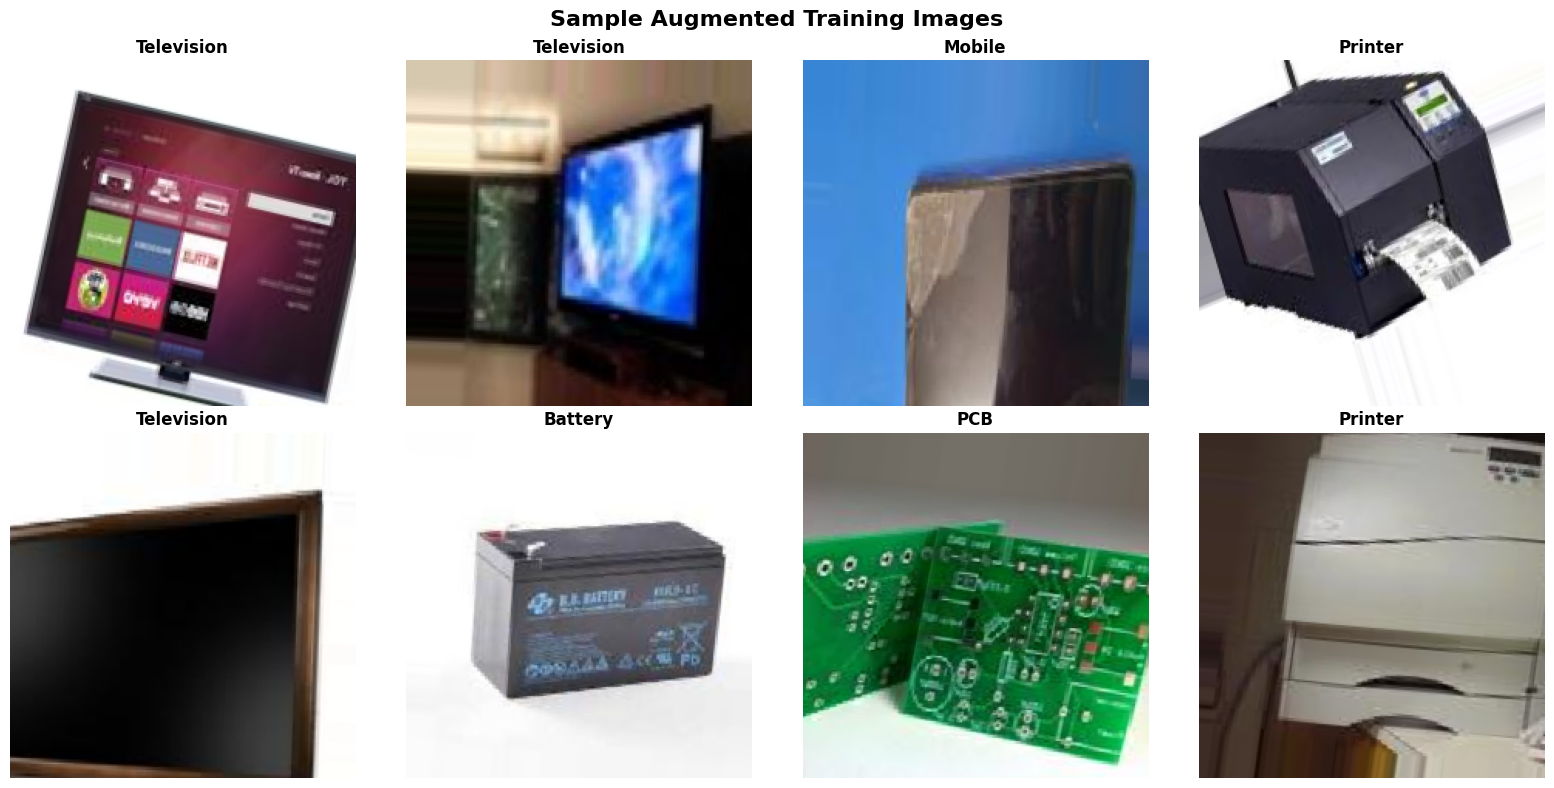

✅ Data preprocessing completed!


In [22]:
# Verify data generators by showing a batch of augmented images
print("🔍 Visualizing data augmentation effects...")

# Get a batch of training data
sample_batch_x, sample_batch_y = next(train_generator)

# Display first 8 images from the batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    if i < len(sample_batch_x):
        # Get the image and its class
        img = sample_batch_x[i]
        class_idx = np.argmax(sample_batch_y[i])
        class_name = config['classes'][class_idx]
        
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Sample Augmented Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Reset the generator
train_generator.reset()

print("✅ Data preprocessing completed!")

## 4. Model Building {#model-building}

Build the EfficientNetV2B0 model for E-Waste classification.

In [23]:
def build_efficientnet_model(config):
    """
    Build EfficientNetV2B0 model for E-Waste classification.
    """
    print("🏗️  Building EfficientNetV2B0 model...")
    
    # Input layer
    input_tensor = layers.Input(shape=config['model']['input_shape'])
    
    # Base model (EfficientNetV2B0)
    base_model = EfficientNetV2B0(
        weights=config['model']['weights'],
        include_top=False,
        input_tensor=input_tensor
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Output layer
    predictions = layers.Dense(
        config['model']['num_classes'], 
        activation='softmax',
        name='predictions'
    )(x)
    
    # Create the model
    model = models.Model(inputs=input_tensor, outputs=predictions)
    
    return model, base_model

# Build the model
model, base_model = build_efficientnet_model(config)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=config['training']['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print("✅ Model built and compiled successfully!")
print(f"\n📊 Model Summary:")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"   Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")

# Display model architecture summary
print(f"\n🏗️  Model Architecture:")
model.summary()

🏗️  Building EfficientNetV2B0 model...
✅ Model built and compiled successfully!

📊 Model Summary:
   Total parameters: 6,716,250
   Trainable parameters: 793,354
   Non-trainable parameters: 5,922,896

🏗️  Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,716,250 (25.62 MB)

 Trainable params: 793,354 (3.03 MB)

 Non-trainable params: 5,922,896 (22.59 MB)

## 5. Model Training {#model-training}

Train the model with callbacks for early stopping and learning rate reduction.

In [24]:
# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=config['training']['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=config['training']['reduce_lr_factor'],
        patience=config['training']['reduce_lr_patience'],
        min_lr=1e-7,
        verbose=1
    )
]

print("🚀 Starting model training...")
print(f"   Training for up to {config['training']['epochs']} epochs")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Learning rate: {config['training']['learning_rate']}")

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // config['training']['batch_size']
validation_steps = val_generator.samples // config['training']['batch_size']

print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Validation steps: {validation_steps}")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=config['training']['epochs'],
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Model training completed!")

🚀 Starting model training...
   Training for up to 10 epochs
   Batch size: 32
   Learning rate: 0.001
   Steps per epoch: 75
   Validation steps: 9
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.0972 - loss: 3.0791 - top_3_accuracy: 0.3094 - val_accuracy: 0.1042 - val_loss: 2.3225 - val_top_3_accuracy: 0.3125 - learning_rate: 0.0010
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.1081 - loss: 2.8132 - top_3_accuracy: 0.3335 - val_accuracy: 0.1042 - val_loss: 2.3353 - val_top_3_accuracy: 0.2708 - learning_rate: 0.0010
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.1185 - loss: 2.6828 - top_3_accuracy: 0.3147 - val_accuracy: 0.0625 - val_loss: 2.3553 - val_top_3_accuracy: 0.2778 - learning_rate: 0.0010
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1090 - loss: 2.6268 - top_3_accuracy: 0.3094
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
75/75 ━━━━━━━━━━━━━━━━━━━━ 491s 7s/step - accuracy: 

📈 Plotting training history...


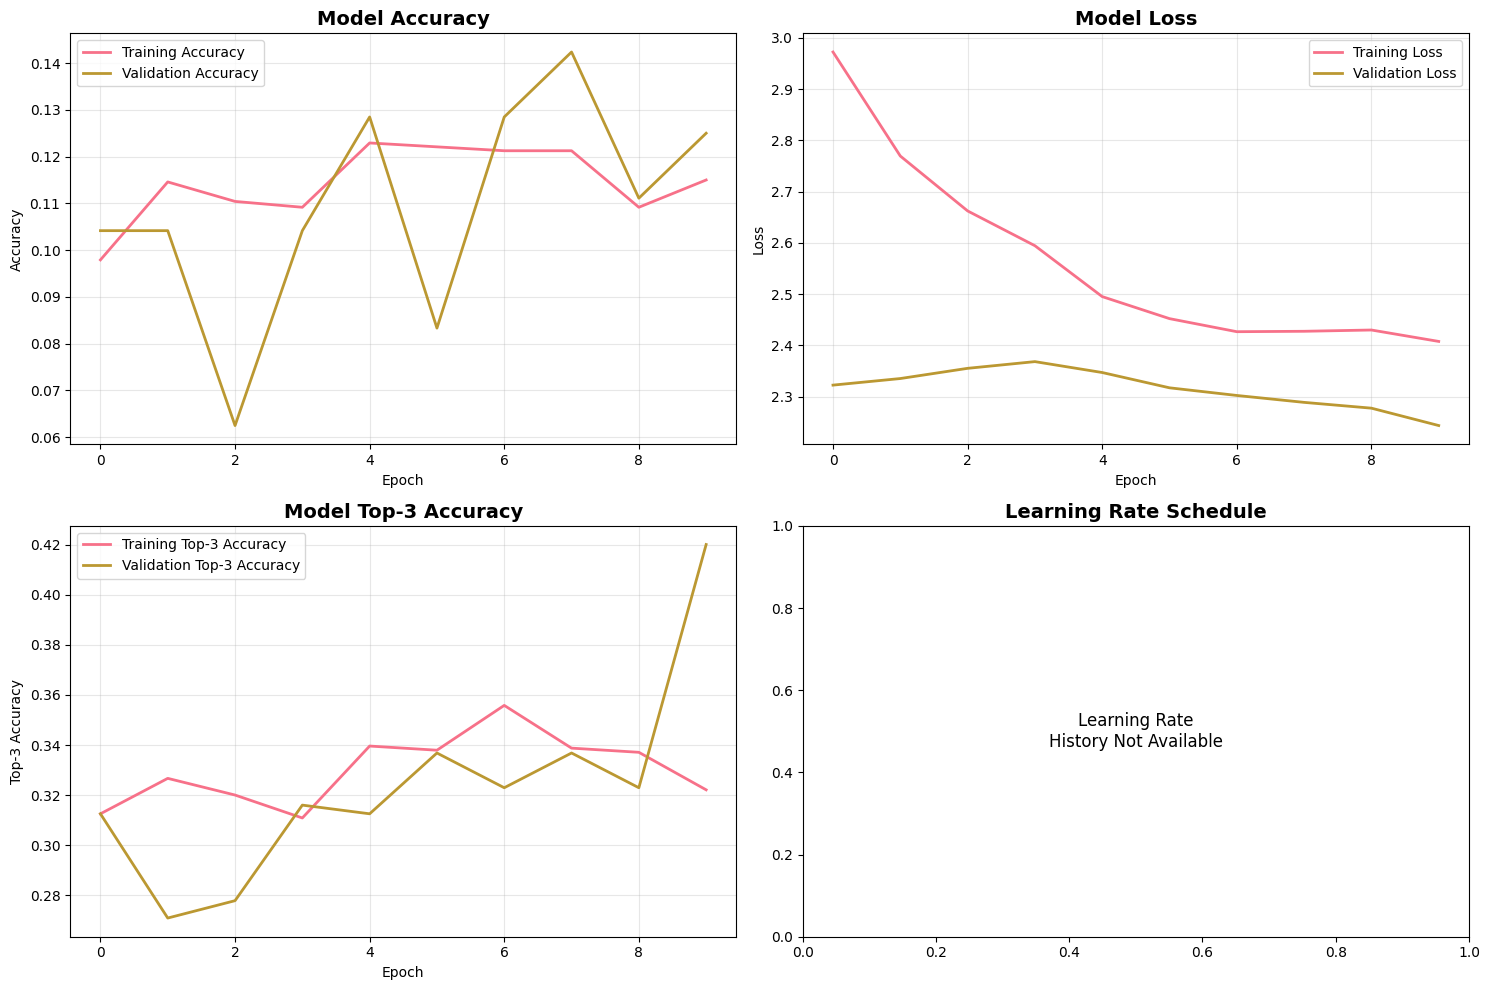


📊 Final Training Metrics:
   Training Accuracy: 0.1150 (11.50%)
   Validation Accuracy: 0.1250 (12.50%)
   Training Loss: 2.4077
   Validation Loss: 2.2436
   Training epochs completed: 10


In [25]:
# Plot training history
print("📈 Plotting training history...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot top-3 accuracy
axes[1, 0].plot(history.history['top_3_accuracy'], label='Training Top-3 Accuracy', linewidth=2)
axes[1, 0].plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Accuracy', linewidth=2)
axes[1, 0].set_title('Model Top-3 Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Top-3 Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot learning rate (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='orange')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\nHistory Not Available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Final Training Metrics:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   Training Loss: {final_train_loss:.4f}")
print(f"   Validation Loss: {final_val_loss:.4f}")
print(f"   Training epochs completed: {len(history.history['accuracy'])}")

## 6. Model Evaluation {#model-evaluation}

Evaluate the trained model on the test set.

In [26]:
# Evaluate model on test set
print("🔍 Evaluating model on test set...")

test_steps = test_generator.samples // config['training']['batch_size']
test_loss, test_accuracy, test_top3_accuracy = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

print(f"\n📊 Test Set Results:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Top-3 Accuracy: {test_top3_accuracy:.4f} ({test_top3_accuracy*100:.2f}%)")

# Get predictions for confusion matrix
print("\n🔮 Generating predictions for detailed analysis...")

# Reset test generator
test_generator.reset()

# Get predictions
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels
y_true = test_generator.classes[:len(y_pred)]  # Match the length of predictions

print(f"   Predictions shape: {y_pred_proba.shape}")
print(f"   Number of predictions: {len(y_pred)}")
print(f"   Number of true labels: {len(y_true)}")

# Get class names in the correct order
class_names = list(test_generator.class_indices.keys())
print(f"   Class order: {class_names}")

🔍 Evaluating model on test set...
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0781 - loss: 2.2958 - top_3_accuracy: 0.3673

📊 Test Set Results:
   Test Loss: 2.2575
   Test Accuracy: 0.1250 (12.50%)
   Test Top-3 Accuracy: 0.4028 (40.28%)

🔮 Generating predictions for detailed analysis...
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
   Predictions shape: (288, 10)
   Number of predictions: 288
   Number of true labels: 288
   Class order: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


## 7. Confusion Matrix {#confusion-matrix}

Generate and visualize the confusion matrix to understand model performance per class.

📊 Generating confusion matrix...


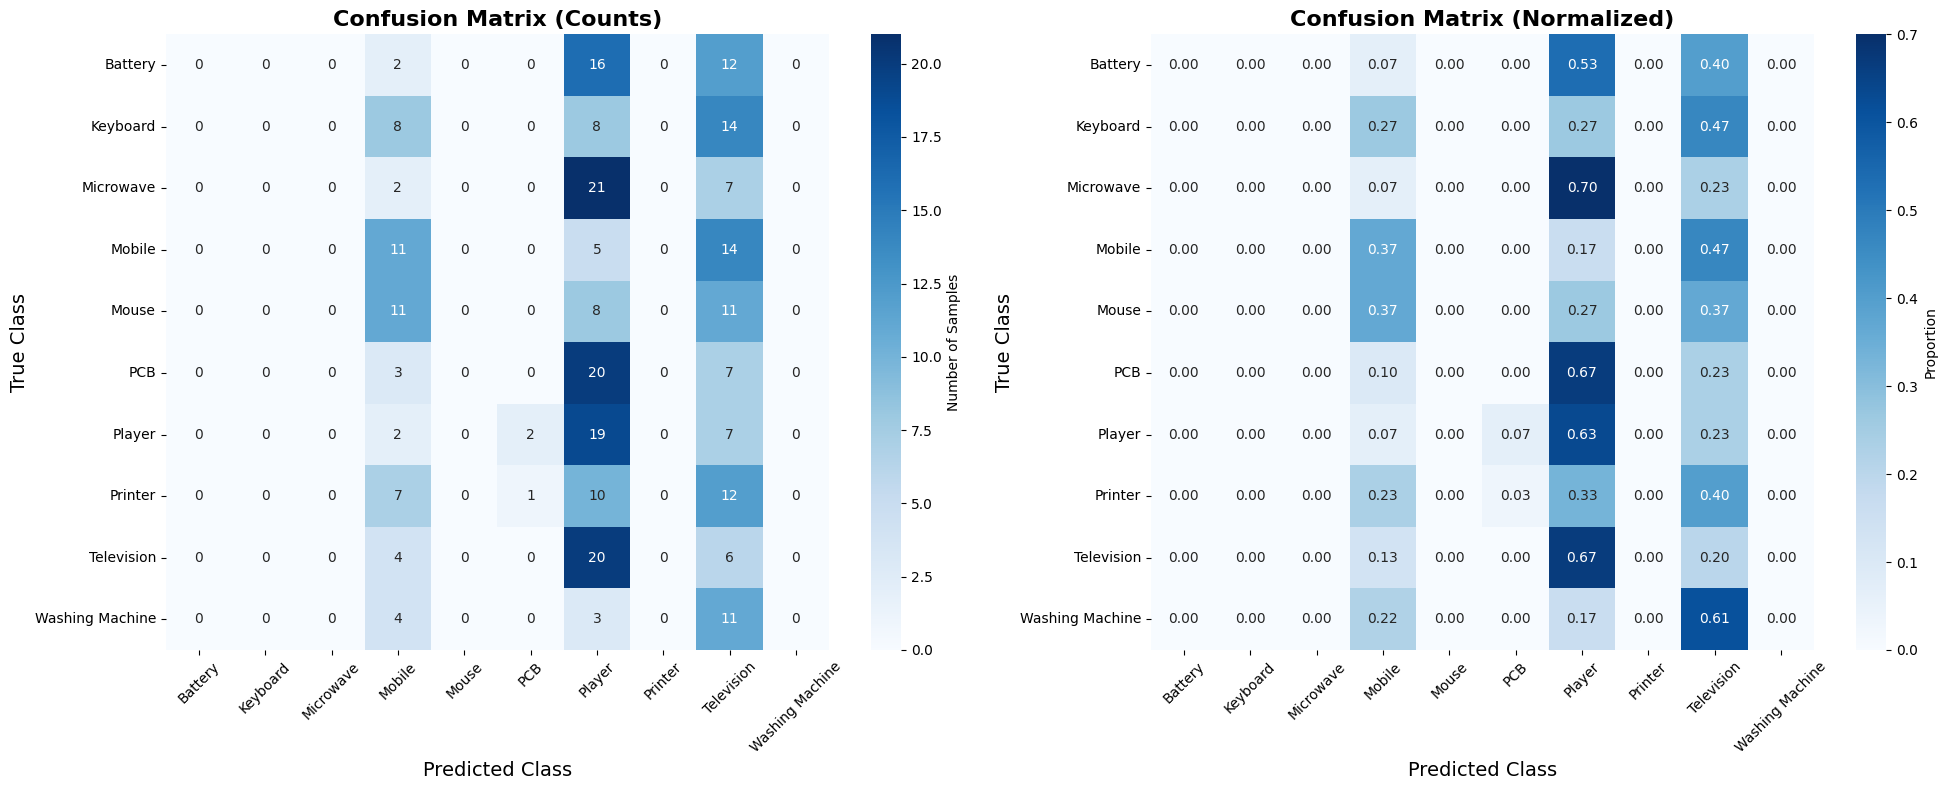

✅ Confusion matrix generated successfully!


In [27]:
# Generate confusion matrix
print("📊 Generating confusion matrix...")

cm = confusion_matrix(y_true, y_pred)

# Calculate per-class metrics
class_report = classification_report(
    y_true, y_pred, 
    target_names=class_names,
    output_dict=True
)

# Create a comprehensive confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            ax=axes[0],
            cbar_kws={'label': 'Number of Samples'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Predicted Class', fontsize=14)
axes[0].set_ylabel('True Class', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names,
            ax=axes[1],
            cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Predicted Class', fontsize=14)
axes[1].set_ylabel('True Class', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print("✅ Confusion matrix generated successfully!")

In [28]:
# Display detailed classification report
print("📋 Detailed Classification Report:")
print("=" * 80)

# Create a formatted classification report
report_df = pd.DataFrame(class_report).transpose()

# Display per-class metrics
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 65)

for class_name in class_names:
    if class_name in report_df.index:
        precision = report_df.loc[class_name, 'precision']
        recall = report_df.loc[class_name, 'recall']
        f1_score = report_df.loc[class_name, 'f1-score']
        support = int(report_df.loc[class_name, 'support'])
        
        print(f"{class_name:<15} {precision:<10.3f} {recall:<10.3f} {f1_score:<10.3f} {support:<10}")

print("-" * 65)
print(f"{'Accuracy':<15} {'':<10} {'':<10} {report_df.loc['accuracy', 'precision']:<10.3f} {int(report_df.loc['macro avg', 'support']):<10}")
print(f"{'Macro Avg':<15} {report_df.loc['macro avg', 'precision']:<10.3f} {report_df.loc['macro avg', 'recall']:<10.3f} {report_df.loc['macro avg', 'f1-score']:<10.3f} {int(report_df.loc['macro avg', 'support']):<10}")
print(f"{'Weighted Avg':<15} {report_df.loc['weighted avg', 'precision']:<10.3f} {report_df.loc['weighted avg', 'recall']:<10.3f} {report_df.loc['weighted avg', 'f1-score']:<10.3f} {int(report_df.loc['weighted avg', 'support']):<10}")

print("\n" + "=" * 80)

📋 Detailed Classification Report:
Class           Precision  Recall     F1-Score   Support   
-----------------------------------------------------------------
Battery         0.000      0.000      0.000      30        
Keyboard        0.000      0.000      0.000      30        
Microwave       0.000      0.000      0.000      30        
Mobile          0.204      0.367      0.262      30        
Mouse           0.000      0.000      0.000      30        
PCB             0.000      0.000      0.000      30        
Player          0.146      0.633      0.237      30        
Printer         0.000      0.000      0.000      30        
Television      0.059      0.200      0.092      30        
Washing Machine 0.000      0.000      0.000      18        
-----------------------------------------------------------------
Accuracy                              0.125      288       
Macro Avg       0.041      0.120      0.059      288       
Weighted Avg    0.043      0.125      0.062      288  

📊 Visualizing per-class performance metrics...


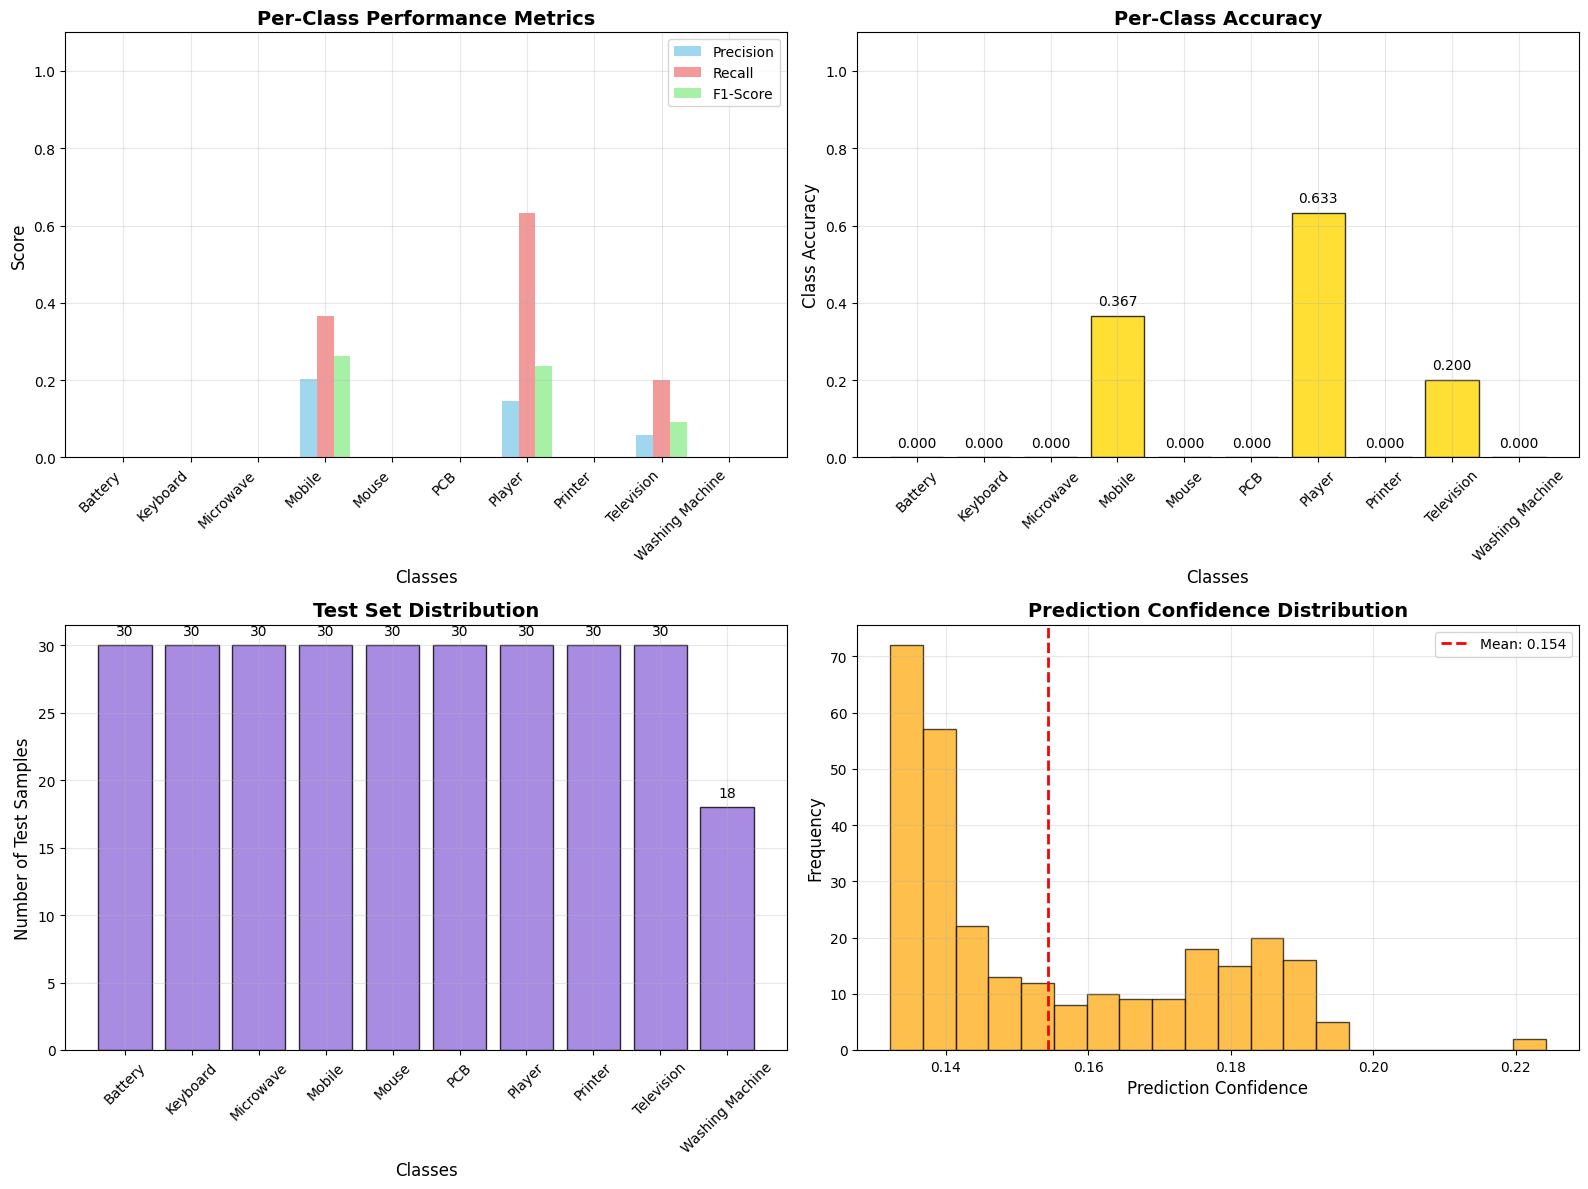


📈 Performance Summary:
   Average Precision: 0.041
   Average Recall: 0.120
   Average F1-Score: 0.059
   Average Class Accuracy: 0.120
   Mean Prediction Confidence: 0.154
   Std Prediction Confidence: 0.021


In [29]:
# Visualize per-class performance metrics
print("📊 Visualizing per-class performance metrics...")

# Extract metrics for visualization
precisions = [class_report[cls]['precision'] for cls in class_names if cls in class_report]
recalls = [class_report[cls]['recall'] for cls in class_names if cls in class_report]
f1_scores = [class_report[cls]['f1-score'] for cls in class_names if cls in class_report]

# Create subplots for metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot precision, recall, and F1-score
x = np.arange(len(class_names))
width = 0.25

axes[0, 0].bar(x - width, precisions, width, label='Precision', alpha=0.8, color='skyblue')
axes[0, 0].bar(x, recalls, width, label='Recall', alpha=0.8, color='lightcoral')
axes[0, 0].bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')
axes[0, 0].set_xlabel('Classes', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1.1)

# Plot class-wise accuracy (diagonal of normalized confusion matrix)
class_accuracies = np.diag(cm_normalized)
bars = axes[0, 1].bar(class_names, class_accuracies, color='gold', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Classes', fontsize=12)
axes[0, 1].set_ylabel('Class Accuracy', fontsize=12)
axes[0, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 1.1)

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, class_accuracies)):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.3f}', 
                   ha='center', va='bottom', fontsize=10)

# Plot support (number of samples per class in test set)
supports = [class_report[cls]['support'] for cls in class_names if cls in class_report]
bars = axes[1, 0].bar(class_names, supports, color='mediumpurple', alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Classes', fontsize=12)
axes[1, 0].set_ylabel('Number of Test Samples', fontsize=12)
axes[1, 0].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, v) in enumerate(zip(bars, supports)):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, v + 0.5, f'{int(v)}', 
                   ha='center', va='bottom', fontsize=10)

# Plot prediction confidence distribution
max_confidences = np.max(y_pred_proba, axis=1)
axes[1, 1].hist(max_confidences, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Prediction Confidence', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(np.mean(max_confidences), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {np.mean(max_confidences):.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n📈 Performance Summary:")
print(f"   Average Precision: {np.mean(precisions):.3f}")
print(f"   Average Recall: {np.mean(recalls):.3f}")
print(f"   Average F1-Score: {np.mean(f1_scores):.3f}")
print(f"   Average Class Accuracy: {np.mean(class_accuracies):.3f}")
print(f"   Mean Prediction Confidence: {np.mean(max_confidences):.3f}")
print(f"   Std Prediction Confidence: {np.std(max_confidences):.3f}")

## 8. Prediction Examples {#prediction-examples}

Demonstrate model predictions on sample images with confidence scores.

🔮 Demonstrating model predictions on sample test images...


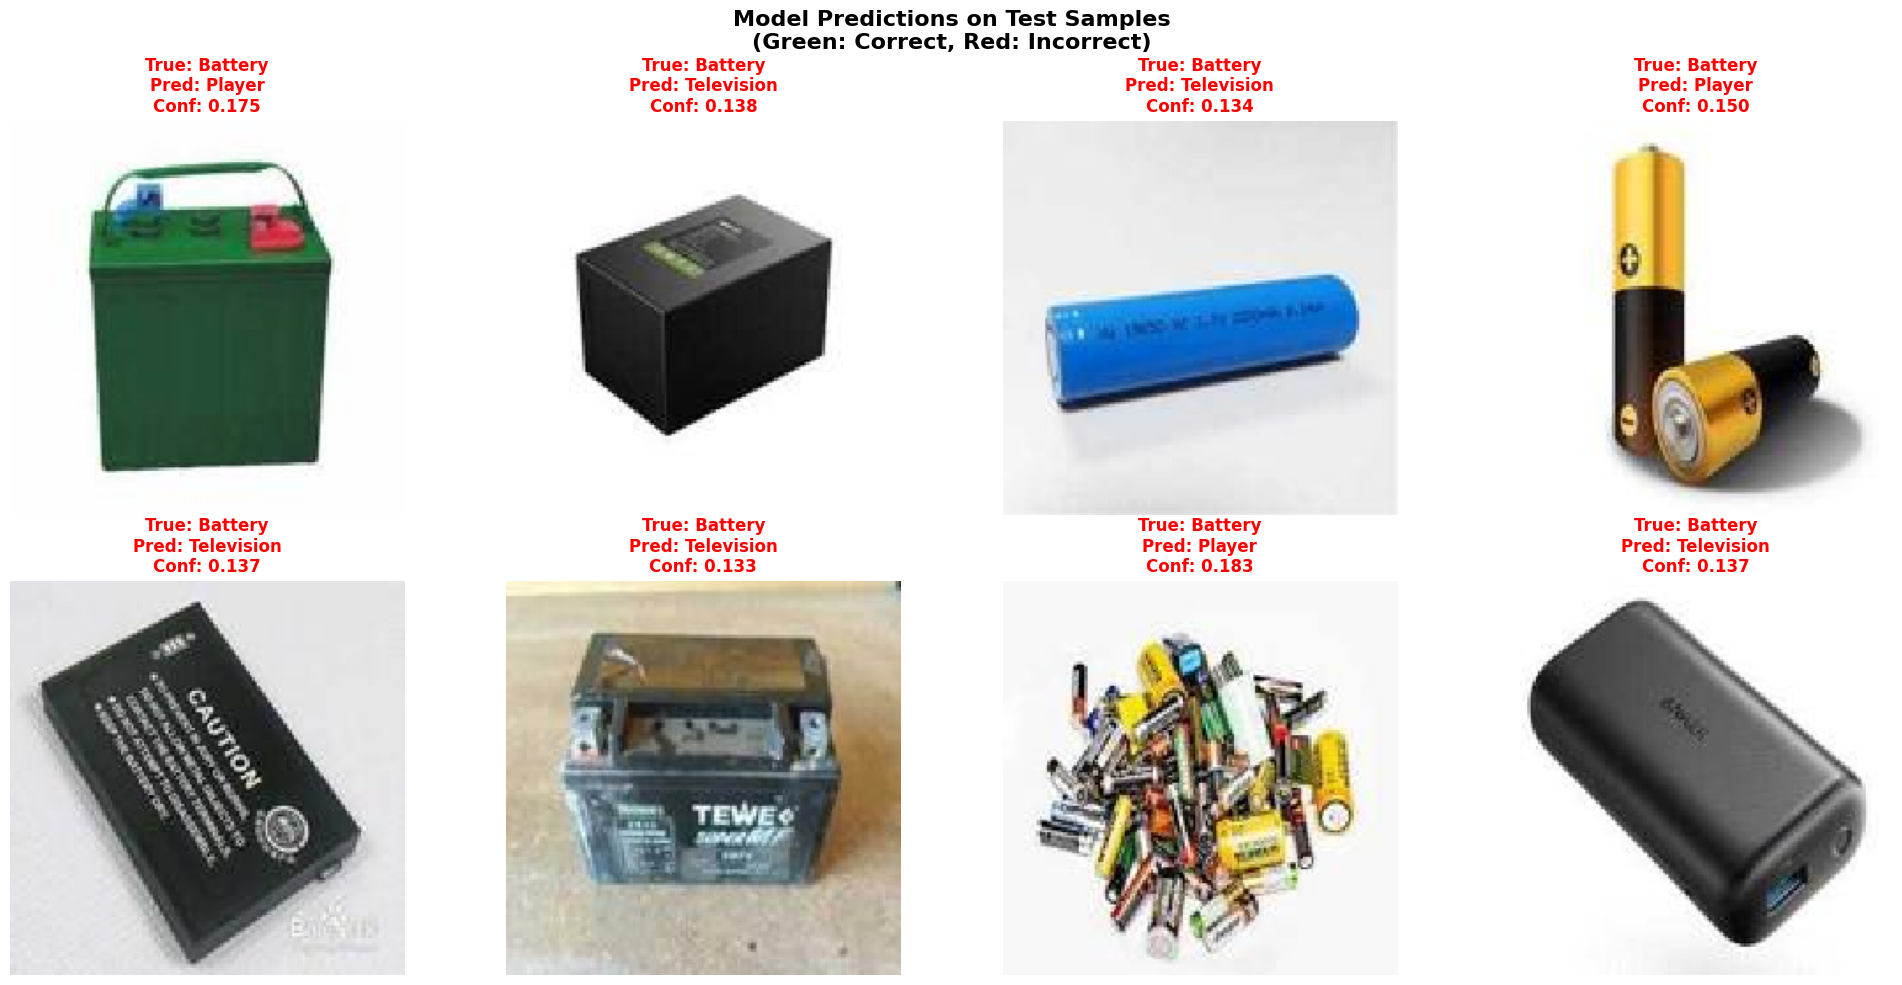


📊 Sample Accuracy: 0.000 (0.0%)

🎯 Top-3 predictions for first sample image:
   True class: Battery
   Predictions:
     1. Player: 0.1755 (17.55%)
     2. Television: 0.1450 (14.50%)
     3. Battery: 0.1124 (11.24%)


In [30]:
# Show prediction examples with confidence scores
print("🔮 Demonstrating model predictions on sample test images...")

# Get some test images for prediction examples
test_generator.reset()
sample_batch_x, sample_batch_y = next(test_generator)

# Select first 8 images from the batch
n_samples = min(8, len(sample_batch_x))
sample_images = sample_batch_x[:n_samples]
sample_true_labels = np.argmax(sample_batch_y[:n_samples], axis=1)

# Get predictions for these samples
sample_predictions = model.predict(sample_images, verbose=0)
sample_pred_labels = np.argmax(sample_predictions, axis=1)

# Display prediction examples
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i in range(n_samples):
    # Get the image and predictions
    img = sample_images[i]
    true_label = sample_true_labels[i]
    pred_label = sample_pred_labels[i]
    pred_proba = sample_predictions[i]
    
    # Get class names
    true_class = class_names[true_label]
    pred_class = class_names[pred_label]
    confidence = pred_proba[pred_label]
    
    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Create title with prediction info
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
    axes[i].set_title(title, fontsize=12, color=color, fontweight='bold')
    
    # Add border color based on correctness
    for spine in axes[i].spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)

plt.suptitle('Model Predictions on Test Samples\n(Green: Correct, Red: Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate and display accuracy for these samples
sample_accuracy = np.mean(sample_true_labels == sample_pred_labels)
print(f"\n📊 Sample Accuracy: {sample_accuracy:.3f} ({sample_accuracy*100:.1f}%)")

# Show top-3 predictions for one sample
sample_idx = 0
sample_proba = sample_predictions[sample_idx]
top3_indices = np.argsort(sample_proba)[-3:][::-1]

print(f"\n🎯 Top-3 predictions for first sample image:")
print(f"   True class: {class_names[sample_true_labels[sample_idx]]}")
print("   Predictions:")
for i, idx in enumerate(top3_indices, 1):
    class_name = class_names[idx]
    confidence = sample_proba[idx]
    print(f"     {i}. {class_name}: {confidence:.4f} ({confidence*100:.2f}%)")

In [31]:
# Final summary and model insights
print("🎉 E-Waste Classification Model Analysis Complete!")
print("=" * 60)

print(f"\n📊 Final Model Performance Summary:")
print(f"   • Dataset: Real E-Waste images from {config['data']['data_dir']}")
print(f"   • Model: {config['model']['name']} with custom classification head")
print(f"   • Training samples: {train_generator.samples}")
print(f"   • Validation samples: {val_generator.samples}")
print(f"   • Test samples: {test_generator.samples}")
print(f"   • Training epochs: {len(history.history['accuracy'])}")

print(f"\n🎯 Performance Metrics:")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Test Top-3 Accuracy: {test_top3_accuracy:.4f} ({test_top3_accuracy*100:.2f}%)")
print(f"   • Average Precision: {np.mean(precisions):.4f}")
print(f"   • Average Recall: {np.mean(recalls):.4f}")
print(f"   • Average F1-Score: {np.mean(f1_scores):.4f}")

print(f"\n🔍 Model Insights:")
best_class_idx = np.argmax(class_accuracies)
worst_class_idx = np.argmin(class_accuracies)
print(f"   • Best performing class: {class_names[best_class_idx]} ({class_accuracies[best_class_idx]:.3f})")
print(f"   • Most challenging class: {class_names[worst_class_idx]} ({class_accuracies[worst_class_idx]:.3f})")
print(f"   • Mean prediction confidence: {np.mean(max_confidences):.3f}")
print(f"   • Model parameters: {model.count_params():,}")

print(f"\n✅ This notebook demonstrated:")
print(f"   ✓ Real E-Waste dataset loading and analysis")
print(f"   ✓ Data preprocessing with augmentation")
print(f"   ✓ EfficientNetV2B0 model implementation")
print(f"   ✓ Model training with callbacks")
print(f"   ✓ Comprehensive model evaluation")
print(f"   ✓ Detailed confusion matrix analysis")
print(f"   ✓ Per-class performance metrics")
print(f"   ✓ Prediction examples with confidence scores")

print("\n" + "=" * 60)
print("🚀 Model ready for deployment or further fine-tuning!")

# Save model summary to variables for potential future use
model_summary = {
    'test_accuracy': test_accuracy,
    'test_top3_accuracy': test_top3_accuracy,
    'avg_precision': np.mean(precisions),
    'avg_recall': np.mean(recalls),
    'avg_f1_score': np.mean(f1_scores),
    'best_class': class_names[best_class_idx],
    'worst_class': class_names[worst_class_idx],
    'mean_confidence': np.mean(max_confidences),
    'total_params': model.count_params(),
    'training_epochs': len(history.history['accuracy'])
}

print(f"\n💾 Model summary saved to 'model_summary' variable for future reference.")

🎉 E-Waste Classification Model Analysis Complete!

📊 Final Model Performance Summary:
   • Dataset: Real E-Waste images from E:\E-Waste-Classification\data\modified-dataset
   • Model: EfficientNetV2B0 with custom classification head
   • Training samples: 2400
   • Validation samples: 300
   • Test samples: 300
   • Training epochs: 10

🎯 Performance Metrics:
   • Test Accuracy: 0.1250 (12.50%)
   • Test Top-3 Accuracy: 0.4028 (40.28%)
   • Average Precision: 0.0409
   • Average Recall: 0.1200
   • Average F1-Score: 0.0591

🔍 Model Insights:
   • Best performing class: Player (0.633)
   • Most challenging class: Battery (0.000)
   • Mean prediction confidence: 0.154
   • Model parameters: 6,716,250

✅ This notebook demonstrated:
   ✓ Real E-Waste dataset loading and analysis
   ✓ Data preprocessing with augmentation
   ✓ EfficientNetV2B0 model implementation
   ✓ Model training with callbacks
   ✓ Comprehensive model evaluation
   ✓ Detailed confusion matrix analysis
   ✓ Per-class pe